In [1]:
import pint
si = pint.UnitRegistry()

In [2]:
from scipy.stats import lognorm

In [3]:
%run parcel.ipynb

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
si.setup_matplotlib()

In [5]:
rd = exp(np.linspace(
    log(10.85), 
    log(503),
    100
))[::-1] * si.nanometre

# from table 1 
assert round(rd[  1-1].magnitude, 0) == 503
assert round(rd[ 10-1].magnitude, 0) == 355
assert round(rd[ 50-1].magnitude, 1) == 75.3
assert round(rd[100-1].magnitude, 1) == 10.8

rd = rd[::-1]

In [6]:
T0 = 284.3 * si.kelvin
q0 = 7.6 * si.grams / si.kilogram
p0 = 938.5 * si.hectopascals
# density of air\n",
rho = p0 / phys(si).R(q0) / T0

In [7]:
rm = 50 * si.nanometre
sg = 1.4

nd = lognorm.pdf(rd.magnitude, log(sg), 0, rm.magnitude)
nd *= 1000 / np.sum(nd) / si.milligram # TODO !!! /cm3 w artykule !!!


dr = rd[1:] - rd[0:-1]

dn_dr = (nd[0:-1] * rho / dr).to(1/si.centimetre**3 / si.nanometre)


# from fig. 1b
assert dn_dr.magnitude[0] > 1e-2 and dn_dr.magnitude[0] < 1e-1
assert max(dn_dr.magnitude) > 1e1 and max(dn_dr.magnitude) < 1e2
assert dn_dr.magnitude[-1] < 1e-9

<IPython.core.display.Javascript object>


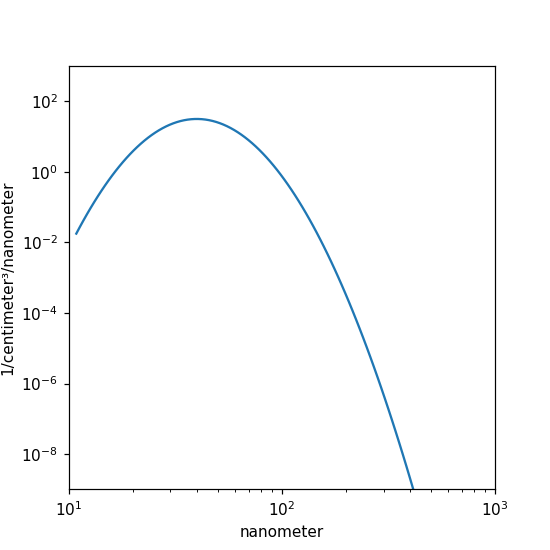

([<matplotlib.axis.YTick at 0x7f3bececce48>,
 <a list of 6 Text yticklabel objects>)

In [8]:
plt.figure(figsize=(5,5))
plt.plot(rd[0:-1], dn_dr)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e1, 1e3)
plt.ylim(1e-9, 1e3)
plt.yticks(10.**np.arange(-8, 3, step=2))  

In [49]:
t0 = 1200 * si.second
f0 = 1 /1000 * si.hertz

w = lambda t: .5 * (np.where(t < t0, 1, np.sign(-np.sin(2*np.pi * f0 * (t-t0))))) * si.metre / si.second
integ, sys = parcel(
    si = si,
    t = 3 * 3600 * si.seconds,
    T0 = T0,
    q0 = q0,
    p0 = p0,
    w = w,
    nd = nd, 
    rd = rd, 
    kp = 0.53,  #Petters and S. M. Kreidenweis mean derived
    dt_max = .5 * si.second,
    thermo = ('S','p')
)

KeyboardInterrupt: 

In [19]:
ix = sys.ix
fn = sys.fn
ph = sys.ph

In [20]:
p = integ.y[ix.p] * ix.p_unit
r = fn.r(integ.y[ix.x] * ix.x_unit)
t = integ.t * ix.t_unit
S = integ.y[ix.S] * ix.S_unit

In [21]:
h0 = 600 * si.metre
h = lambda t: h0 + np.cumsum(w(t) *np.append(0,np.diff(t.magnitude)) *si.second) 
h = h(t)

<IPython.core.display.Javascript object>


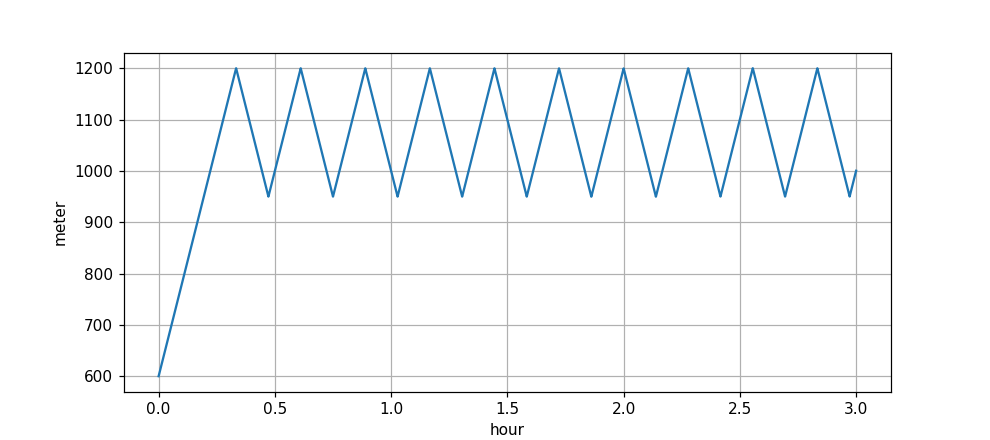

In [22]:
fig, ax = plt.subplots(1, 1,  figsize=(9,4))

# plt.xticks([])
# plt.yticks([])

ax.plot(t, h, label="T")
ax.grid()
ax.xaxis.set_units(si.hours)

In [47]:
ix51 = 40
ix503 = 99
assert round(rd[  ix51].magnitude, 0) == 51
assert round(rd[ ix503].magnitude, 0) == 503

<IPython.core.display.Javascript object>


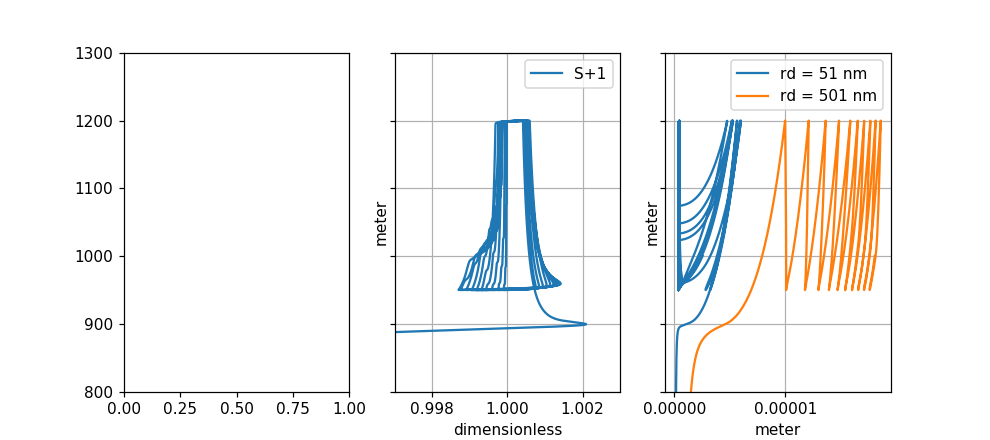

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9,4))

# plt.xticks([])
# plt.yticks([])
ax1.set_ylim([800, 1300])

# ax1.plot(sys.q1 - ph.q(sys.q1, sys.nd, 0), h, label="T")
# ax1.grid()
# ax1.legend()
# ax1.xaxis.set_units(si.celsius)

ax2.plot(S+1, h, label="S+1")
ax2.grid()
ax2.legend()
ax2.set_xlim([0.997, 1.003])


ax3.plot(r[ix51], h, label="rd = 51 nm")
ax3.plot(r[ix503], h, label="rd = 501 nm")
ax3.grid()
ax3.legend()



<IPython.core.display.Javascript object>


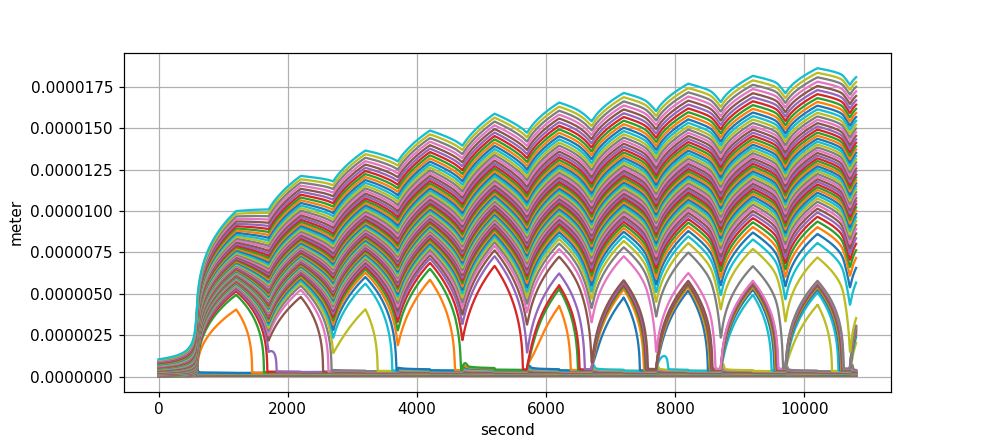

In [27]:
plt.figure(figsize=(9,4))
for i in range(ix.x.stop - ix.x.start):
    plt.plot(t, r[i], label="r_"+str(i))

# plt.xscale('log')
# plt.yscale('log')
plt.grid()
# plt.legend()

# plt.savefig('pics/spectrum.pdf')

plt.show()